# INF552 Assignment1 KNN Classification
### Tong Lyu 1076139647

## 1 Introduction
### 1.1 Libraries

In [164]:
import numpy as np;
import pandas as pd;
import seaborn as sns;
import matplotlib.pyplot as plt;
from sklearn import neighbors
from matplotlib.ticker import MultipleLocator
from sklearn.metrics import classification_report, confusion_matrix  
%matplotlib inline

## 2. Pre-Processing and Exploratory data analysis
### 2.1 Load Data and  make scatterplots
The table of abbreviations and corresponding independent variables is as follows:

|Independent variables|Abbreviations
| :------: | :------: |
|pelvic incidence|PEI
|pelvic tilt|PET
|lumbar lordosis angle|LLA
|sacral slope|SAS
|pelvic radius|PER
|grade of spondylolisthesis|GOS

<Figure size 432x432 with 0 Axes>

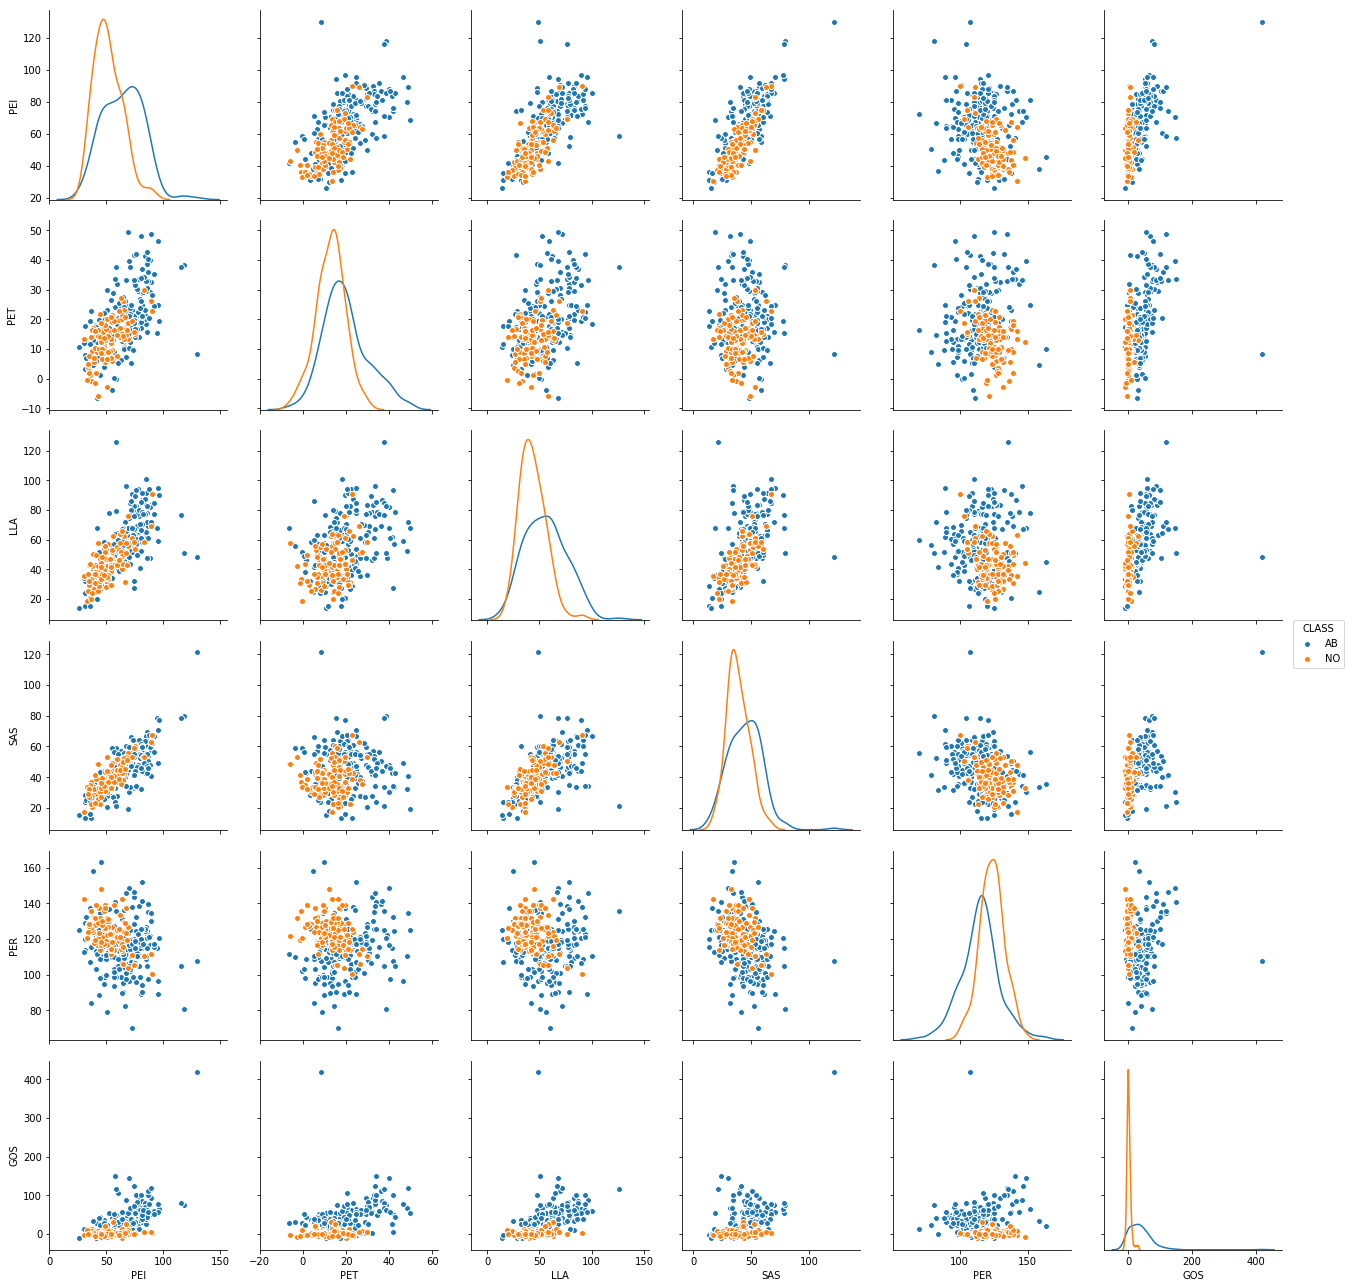

In [165]:
columns = ["PEI","PET","LLA","SAS","PER","GOS","CLASS"]
data = pd.read_csv("./data/column_2C.dat",sep=" ",header=None, names=columns)
plt.figure(figsize=(6,6))
sns.pairplot(data,hue="CLASS",size=3, diag_kind='kde')
plt.show()

### 2.2 Make boxplots for each of the independent variables

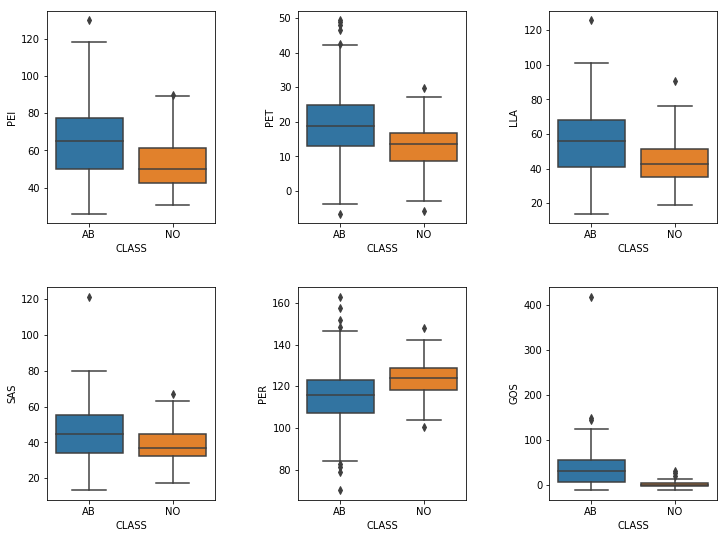

In [166]:
attributes = ["PEI","PET","LLA","SAS","PER","GOS"]
plt.figure(figsize=(12,9))
plt.subplots_adjust(hspace=0.3, wspace=0.5)
arrange = 230
for attr in attributes:
    arrange += 1
    plt.subplot(arrange)
    sns.boxplot(data=data,x="CLASS",y=attr)

### 2.3 Select training dataset and test dataset
Select the ﬁrst 70 rows of Class 0 and the ﬁrst 140 rows of Class 1 as the training set and the rest of the data as the test set.

In [167]:
def tranCat2Num(category):
    if (category == "AB"):
        return 1
    else:
        return 0
    
data["CLASS"] = data.apply(lambda row: tranCat2Num(row["CLASS"]), axis=1)
train_AB = data.loc[0:139]
test_AB = data.loc[140:209]
train_NO = data.loc[210:279]
test_NO = data.loc[280:309]
train = pd.concat([train_AB,train_NO])
test = pd.concat([test_AB, test_NO])

## 3. Classiﬁcation using KNN
### 3.1 Explore effect of neighbors K

In this session, we built KNN classifier with Euclidean distance and different numbers of neighbors, k ∈ {208, 207, . . . , 3, 2, 1, }.   
The result showed the optimal neighbors for this set up is 4.

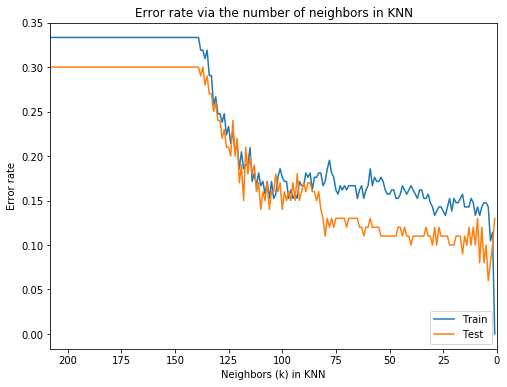

In [168]:
def knn_k():
    train_err = []
    test_err = []
    nei = np.arange(1,209)

    for k in nei:
        knn_k = neighbors.KNeighborsClassifier(k, metric="euclidean")
        knn_k.fit(train[attributes], train["CLASS"])

        train_err.append(1 - knn_k.score(train[attributes], train["CLASS"]))
        test_err.append(1 - knn_k.score(test[attributes], test["CLASS"]))

    opt_k = nei[test_err.index(min(test_err))]
    return nei,train_err,test_err,opt_k, lowest_TER

nei,train_err,test_err, opt_k, lowest_TER = knn_k()
low = [lowest_TER]

fig = plt.figure(figsize=(8,6))
plt.plot(nei, train_err, label='Train')
plt.plot(nei, test_err, label='Test')
plt.legend(loc='lower right')
plt.xlim(0,208)
plt.xlabel('Neighbors (k) in KNN')
plt.ylabel('Error rate')
plt.title("Error rate via the number of neighbors in KNN")
ax = plt.gca()
ax.invert_xaxis()

In [169]:
opt = neighbors.KNeighborsClassifier(opt_k, metric="euclidean")
opt.fit(train[attributes], train["CLASS"])
pred = opt.predict(test[attributes])
con_matrix = confusion_matrix(test["CLASS"], pred) 
TP = con_matrix[1][1]
FP = con_matrix[1][0]
TN = con_matrix[0][0]
FN = con_matrix[0][1]

print("The optimal number of neighbors(k) is " + str(opt_k) +".\n")
print("The confusion matrix is:")
print("\t| predicted AB\t| predicted NO")
print("real AB\t| "+str(TP)+"\t\t| "+str(FN))
print("real NO\t| "+str(FP) +"\t\t| "+str(TN))

TP_rate = float(TP)/(TP + FN)
TN_rate = float(TN)/(FP+ TN)
precision = float(TP)/(TP + FP)
recall = float(TP)/(TP + FN)
F1_score = (2 * precision * recall) / (precision + recall)

print("\nTrue positive rate = %.2f" %TP_rate)
print("True negotive rate = %.2f" %TN_rate)
print("Precision = %.2f" %precision)
print("F1 score = %.2f" %F1_score)


The optimal number of neighbors(k) is 4.

The confusion matrix is:
	| predicted AB	| predicted NO
real AB	| 69		| 5
real NO	| 1		| 25

True positive rate = 0.93
True negotive rate = 0.96
Precision = 0.99
F1 score = 0.96


### 3.2 Explore the effect of size of the training dataset

[0.00952380952380949, 0.00952380952380949]


Text(0.5,1,'Learning Curve (test error rate) via the size of training dataset')

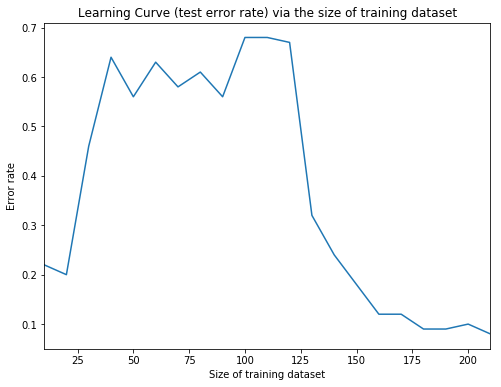

In [170]:
def knn_N():
    test_err = []
    train_err = []
    nei = np.arange(1,200,5)
    
    N = np.arange(10,220,10)
    for number in N:
        max_acc = 0
        n = int(number / 2)
        neis = [i for i in nei if i <= n]
        for k in neis:
            trainsub = pd.concat([train_AB.iloc[:n],train_NO.iloc[:n]])
            knn_N = neighbors.KNeighborsClassifier(k, p=2, metric="minkowski")
            knn_N.fit(trainsub[attributes], trainsub["CLASS"])
            score = knn_N.score(test[attributes], test["CLASS"])
            train_err.append(1 - knn_N.score(train[attributes], train["CLASS"]))
            max_acc = max(max_acc, score)
        test_err.append(1 - max_acc)
    return N,test_err, min(train_err)

N, test_err, lowest_TER  = knn_N()
low.append(lowest_TER)
print(low)
fig = plt.figure(figsize=(8,6))
plt.plot(N, test_err, label='Test')
plt.xlim(10,210)
plt.xlabel('Size of training dataset')
plt.ylabel('Error rate')
plt.title("Learning Curve (test error rate) via the size of training dataset")

## 4. Distance Metrics
### 4.1 Mahanttan distance

In [171]:
def knn_manhattan():
    nei = np.arange(1,200,5)
    max_acc = 0
    opt_k = 0
    for k in nei:
        knn_manhattan = neighbors.KNeighborsClassifier(k, algorithm = "auto",metric="manhattan")
        knn_manhattan.fit(train[attributes], train["CLASS"])
        score = knn_manhattan.score(test[attributes], test["CLASS"])
        if score > max_acc :
            max_acc = score
            opt_k = k
    test_err = 1 - max_acc
    return opt_k,test_err

opt_k_man, test_err_man = knn_manhattan()
print("The optimal k for KNN Classifier with Manhattan distance is %d" %opt_k_man)
print("The corresponding test error rate (k=%d) is %.2f" %(opt_k_man,test_err_man))

The optimal k for KNN Classifier with Manhattan distance is 6
The corresponding test error rate (k=6) is 0.11


### 4.2 Best Log_10(p) in Minkowski distance

In [172]:
def knn_log():
    power_p = np.arange(0.1,1.1,0.1)
    p_list = list(map(lambda x: pow(10,x),power_p))

    max_acc = 0
    opt_p = p_list[0]
    for p_metric in p_list:
        knn_log = neighbors.KNeighborsClassifier(opt_k_man, algorithm="auto",p=p_metric, metric="minkowski")
        knn_log.fit(train[attributes], train["CLASS"])
        score = knn_log.score(test[attributes], test["CLASS"])
        if score > max_acc :
            max_acc = score
            opt_p = p_metric
    test_err = 1 - max_acc
    return power_p[p_list.index(opt_p)], test_err

opt_p_log, test_err_log = knn_log()
print("The optimal log_10(p) for KNN Classifier with Minkowski distance is %.1f" %opt_p_log)
print("The corresponding test error rate (log_10(p)=%.1f) is %.2f" %(opt_p_log,test_err_log))

The optimal log_10(p) for KNN Classifier with Minkowski distance is 0.6
The corresponding test error rate (log_10(p)=0.6) is 0.06


### 4.3 Chebyshev Distance

In [173]:
def knn_chebyshev():
    nei = np.arange(1,200,5)
    max_acc = 0
    opt_k = 0
    for k in nei:
        knn_chebyshev = neighbors.KNeighborsClassifier(k, algorithm="auto",metric="chebyshev")
        knn_chebyshev.fit(train[attributes], train["CLASS"])
        score = knn_chebyshev.score(test[attributes], test["CLASS"])
        if score > max_acc :
            max_acc = score
            opt_k = k
    test_err = 1 - max_acc
    return opt_k,test_err

opt_k_che, test_err_che = knn_chebyshev()
print("The optimal k for KNN Classifier with Chebyshev distance is %d" %opt_k_che)
print("The corresponding test error rate (k=%d) is %.2f" %(opt_k_che ,test_err_che))

The optimal k for KNN Classifier with Chebyshev distance is 16
The corresponding test error rate (k=16) is 0.08


### 4.4 Mahalanobis Distance

In [174]:
def knn_mahalanobis():
    nei = np.arange(1,200,5)
    max_acc = 0
    opt_k = 0
    for k in nei:
        knn_mahalanobis = neighbors.KNeighborsClassifier(k, algorithm="brute",metric="mahalanobis",metric_params={'V': train[attributes].cov()})
        knn_mahalanobis.fit(train[attributes], train["CLASS"])
        score = knn_mahalanobis.score(test[attributes], test["CLASS"])
        if score > max_acc :
            max_acc = score
            opt_k = k
    test_err = 1 - max_acc
    return opt_k,test_err

opt_k_mas, test_err_mas = knn_mahalanobis()
print("The optimal k for KNN Classifier with Mahalanobis distance is %d" %opt_k_mas)
print("The corresponding test error rate (k=%d) is %.2f" %(opt_k_mas,test_err_mas))

The optimal k for KNN Classifier with Mahalanobis distance is 6
The corresponding test error rate (k=6) is 0.16


### Summarized Table
| Distance method|Metrics|Best test error rate
| :------: | :------: | :------: |
|Mahanttan distance| k = 6| 0.11
|Minkowski distance| log_10(p) = 0.6| 0.06
|Chebyshev Distance| k = 16 | 0.08
|Mahalanobis Distance| k = 6|0.16

## 5. Weighted model
### 5.1 Weighted Euclidean distance

In [175]:
def knn_w_euc():
    nei = np.arange(1,200,5)
    max_acc = 0
    opt_k = 0
    
    for k in nei:
        knn_log = neighbors.KNeighborsClassifier(k, weights="distance",algorithm="auto",p=2, metric="minkowski")
        knn_log.fit(train[attributes], train["CLASS"])
        score = knn_log.score(test[attributes], test["CLASS"])
        if score > max_acc :
            max_acc = score
            opt_k = k
    test_err = 1 - max_acc
    return opt_k,test_err

opt_k_w_euc, test_err_w_euc = knn_w_euc()
print("The optimal k for KNN Classifier with weighted Euclidean distance is %d" %opt_k_w_euc)
print("The corresponding test error rate (k=%d) is %.2f" %(opt_k_w_euc,test_err_w_euc))

The optimal k for KNN Classifier with weighted Euclidean distance is 6
The corresponding test error rate (k=6) is 0.10


### 5.2 Weighted Mahanttan distance

In [176]:
def knn_w_man():
    nei = np.arange(1,200,5)
    max_acc = 0
    opt_k = 0
    for k in nei:
        knn_manhattan = neighbors.KNeighborsClassifier(k, weights="distance", algorithm = "auto",metric="manhattan")
        knn_manhattan.fit(train[attributes], train["CLASS"])
        score = knn_manhattan.score(test[attributes], test["CLASS"])
        if score > max_acc :
            max_acc = score
            opt_k = k
    test_err = 1 - max_acc
    return opt_k,test_err

opt_k_w_man, test_err_w_man = knn_w_man()
print("The optimal k for KNN Classifier with Manhattan distance is %d" %opt_k_w_man)
print("The corresponding test error rate (k=%d) is %.2f" %(opt_k_w_man,test_err_w_man))

The optimal k for KNN Classifier with Manhattan distance is 26
The corresponding test error rate (k=26) is 0.10


### 5.3 Weighted Chebyshev distance

In [177]:
def knn_w_che():
    nei = np.arange(1,200,5)
    max_acc = 0
    opt_k = 0
    for k in nei:
        knn_chebyshev = neighbors.KNeighborsClassifier(k, weights="distance",algorithm="auto",metric="chebyshev")
        knn_chebyshev.fit(train[attributes], train["CLASS"])
        score = knn_chebyshev.score(test[attributes], test["CLASS"])
        if score > max_acc :
            max_acc = score
            opt_k = k
    test_err = 1 - max_acc
    return opt_k,test_err

opt_k_w_che, test_err_w_che = knn_w_che()
print("The optimal k for KNN Classifier with Chebyshev distance is %d" %opt_k_w_che)
print("The corresponding test error rate (k=%d) is %.2f" %(opt_k_w_che ,test_err_w_che))

The optimal k for KNN Classifier with Chebyshev distance is 16
The corresponding test error rate (k=16) is 0.11


### Summarized Table
| Distance method|Metrics|Best test error rate
| :------: | :------: | :------: |
|Euclidean Distance| k = 6|0.1
|Mahanttan distance| k = 26| 0.10
|Chebyshev Distance| k = 16 | 0.11